# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding


When calculating the value of a vehicle, several factors typically have a significant impact. The importance of these factors can vary depending on the market and the type of vehicle, but generally, the following are considered key determinants:

1. Make and Model: Certain brands and models are more sought after due to their reputation for quality, reliability, performance, or luxury. High-demand models tend to retain value better.

2. Year and Age: The age of the vehicle, often indicated by the model year, is a crucial factor. Newer vehicles usually have more advanced technology, better fuel efficiency, and lower accumulated wear and tear.

3. Mileage/Odometer Reading: Higher mileage typically leads to lower value due to the wear and tear associated with extensive use.

4. Condition: This includes both mechanical and aesthetic aspects. Vehicles in better condition, with no need for significant repairs or bodywork, are valued higher.

5. Accident History: A history of accidents can significantly reduce a vehicle's value, especially if the accidents were severe.

6. Vehicle History: This includes not just accident history but also ownership history (single owner vs. multiple owners), maintenance records, and whether it was used for personal or commercial purposes.

7. Features and Options: Certain features like advanced safety systems, infotainment, luxury interiors, or high-performance components can add to a vehicle's value.

8. Market Trends and Demand: The local demand for certain types of vehicles (e.g., SUVs, electric cars) can influence their value. Also, broader market trends, such as fuel prices, can impact the value of certain types of vehicles (like gas-guzzlers vs. fuel-efficient models).

9. Economic Factors: General economic conditions, including interest rates and consumer confidence, can affect vehicle values. In a strong economy, people might be willing to pay more for vehicles.

10. Fuel Efficiency: Especially in times of high fuel prices, more fuel-efficient vehicles tend to retain their value better.

11. Location: Vehicle values can vary by region due to differences in demand and usage. For example, four-wheel drives might be more valued in rural or mountainous areas.

12. Color: While it might seem minor, the color of a vehicle can affect its resale value. Common and popular colors like white, black, and silver often have better resale values.





### Data Understanding


Given the columns in vechiles.csv dataset and the factors that typically impact vehicle value, the most important columns to consider for the analysis would likely be:

1) Year (year): The model year of the car is a strong indicator of its age and can significantly influence its value.

2) Manufacturer (manufacturer): The brand of the car often affects its value, as some brands are perceived as more reliable or desirable.

3) Model (model): Different models have varying levels of demand and reputation, which can impact their resale value.

4) Odometer (odometer): The mileage on the car is a key indicator of wear and tear. Generally, lower mileage cars are valued higher.

5) Condition (condition): The overall state of the car, including both mechanical and aesthetic condition, is crucial for determining its value.

---- cutline in my modeling decision ------------------------------------------------------------------------------------------------------------------------------------------------------

6) Transmission (transmission): The type of transmission (automatic, manual) can affect a car's desirability and thus its value.

7) Fuel Type (fuel): Fuel efficiency and type (gas, diesel, electric, hybrid) can influence a car's value, especially in certain markets or during times of fluctuating fuel prices.

8) Drive Type (drive): Whether the car is front-wheel drive, rear-wheel drive, or all-wheel drive can impact its value, particularly in regions with specific weather conditions.

9) Type (type): The body type of the vehicle (SUV, sedan, truck, etc.) can affect its value based on consumer preferences and trends.

10) Paint Color (paint_color): While not as significant as other factors, the color can play a role in the car's appeal and value.

11) Title Status (title_status): Cars with a clean title generally have higher values than those with salvage or rebuilt titles.



### Load all the needed libraries, dataset and initialize global variables

In [1443]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import PolynomialFeatures
from scipy import stats
import copy
import sys
import warnings
from sklearn.preprocessing import RobustScaler


with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UserWarning)

In [1502]:
# load data from file and initialize global variables needed in this task
all_vehicles = pd.read_csv('data/vehicles.csv')
label_encoder = LabelEncoder()
poly = PolynomialFeatures(degree=2, include_bias=False)

condition_mapping = {
    'new': 1000000,
    'like new': 900000,
    'excellent': 800000,
    'good': 700000,
    'fair': 500000,
    'salvage': 1,
    'unknown': 1000000
}

[nan 'good' 'excellent' 'fair' 'like new' 'new' 'salvage']


### Introduce Utility functions that will be used during the CRISP-DM process

In [1445]:
# load data function to return copy of orifinal all vehicle data
def load_data():
    df = all_vehicles
    return df.copy()

In [1446]:
# scopy function to return copy of dataframe where data has been scoped and some NaN values removed
def scope_data(df, manufacturer):
    low_odometer_threshold = 1000 
    low_price_threshold = 5000 
    newest_car_year = df['year'].max()
    cutoff_year = newest_car_year - 15
    df = df[df['year'] >= cutoff_year]
    df = df[df['manufacturer'] == manufacturer]
    df = df[['price', 'year', 'manufacturer', 'model', 'odometer', 'condition']]
    df = df[df['price'] > low_price_threshold]
    df = df[df['odometer'] > low_odometer_threshold]
    df = df.dropna(subset=['manufacturer'])
    df = df.dropna(subset=['model'])
    #df = df.dropna(subset=['odometer'])
    df = df[~((df['odometer'] < 20000) & (df['price'] < 15000))]
    df['condition'] = df['condition'].fillna('unknown')
    df['odometer'] = df['odometer'].fillna(df['odometer'].median())
    df['manufacturer_model'] = df['manufacturer'].astype(str) + "_" + df['model'].astype(str)
    return df.copy()

In [1447]:
# utility function to detect and return outliers
def detect_outliers(data, column):
    multiplier=1.5
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR

    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers

In [1448]:
# utility function to detect and return outliers of a specific car manufacturer and model
def detect_outliers_by_model_and_year(df, column_to_check):
    outliers_dict = {}
    for model in df['manufacturer_model'].unique():
        model_data = df[df['manufacturer_model'] == model]
        for year in model_data['year'].unique():
            year_data = model_data[model_data['year'] == year]
            outliers = detect_outliers(year_data, column_to_check)

            # Storing outliers' information
            if not outliers.empty:
                outliers_dict[(model, year)] = outliers

    return outliers_dict

In [1449]:
# utility function to cleanup outliers from input dataframe outlier dictionary as an input
def clean_outliers(df, outliers_dict):
    cleaned_cars = pd.DataFrame()

    for key, outliers in outliers_dict.items():
        manufacturer_model, year = key

        # Filter the subset for the current manufacturer_model and year
        subset_mask = (df['manufacturer_model'] == manufacturer_model) & (df['year'] == year)
        subset = df[subset_mask]

        # Keep rows that are not in outliers
        non_outliers = subset[~subset.index.isin(outliers.index)]
        
        # Append non-outliers to the cleaned DataFrame
        cleaned_cars = pd.concat([cleaned_cars, non_outliers])

    # Append all other data that wasn't processed (not in outliers_dict)
    for key in outliers_dict.keys():
        manufacturer_model, year = key
        df = df[~((df['manufacturer_model'] == manufacturer_model) & (df['year'] == year))]

    cleaned_cars = pd.concat([cleaned_cars, df])

    return cleaned_cars

In [1450]:
# utility function to convert car condition values (new, excellent, ...) to numerical values
def convert_to_condition_value(condition_str):
    return condition_mapping.get(condition_str, 0) 

In [1451]:
# utility function to convert all non numerical columns to numerical values
def encode_data(df):
    
    df['condition'] = df['condition'].map(condition_mapping)    
    # Apply label encoding to each categorical column
    categorical_columns = df.select_dtypes(include=['object']).columns

    for column in categorical_columns:
        df[column] = label_encoder.fit_transform(df[column].astype(str))
        
    return df.copy()

In [1452]:
# utility function to count number of rows in dataframe that are specific to manufacturer + model
def model_count(df, manufacturer, model):
    return ((df['manufacturer'] == manufacturer) & (df['model'] == model)).sum()

In [1453]:
# utility super function to initialize data including dataloading, scoping, cleanup and encoding
def init_model_data(manufacturer, model):
    manufacturer_lc = manufacturer.lower()
    model_lc = model.lower()
    
    df = load_data()
    df = scope_data(df, manufacturer_lc)
    
    mc = model_count(df, manufacturer_lc, model_lc)
    
    if mc == 0:
        raise ValueError(f"cannot find '{manufacturer}' '{model}'")
    
    outliers_dict = detect_outliers_by_model_and_year(df, 'price')
    df = clean_outliers(df, outliers_dict)
        
    model_data = model_data = df[(df['manufacturer'] == manufacturer.lower()) & (df['model'] == model.lower())]
    model_data = model_data[['price', 'year', 'odometer', 'condition']]
    
    model_data = encode_data(model_data)
    
    return model_data.copy()

In [1454]:
# utility function to count number of unique car models in a dataframe
def unique_carmodels(df):
    unique_manufacturer_models = df['manufacturer_model'].unique()
    print(type(unique_manufacturer_models))
    print(unique_manufacturer_models, len(unique_manufacturer_models))

In [1455]:
# utility function to calculate and plot correlation_matrix for a dataframe
def run_correlation_matrix(df, title):
    # Correlation analysis all models of selected manufacturere
    correlation_matrix = df.corr()
    # Get the correlation of all features with the target variable 'price'
    correlation_with_price = correlation_matrix['price'].sort_values(ascending=False)
    # Print the correlation values
    print(correlation_with_price)

    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap=plt.cm.Reds)
    plt.title(title)
    plt.savefig(f'images/correclation_heatmap_{title}.png')
    plt.show()
    return correlation_matrix

In [1456]:
# utility function to search car manufacturer+model which has the best correlation
def search_best_correlating_model(df):
    unique_models = df['manufacturer_model'].unique()
    model_with_most_strong_correlations = ''
    max_strong_correlations_with_price = ''
    max_strong_correlations = 0

    for carmodel in unique_models:
        # Filter the dataset for the specific model
        model_data = df[df['manufacturer_model'] == carmodel]
        model_data = model_data.drop(['manufacturer_model'], axis=1)
        
        # Ensure there's enough data for the specific model
        if model_data.shape[0] > 500:  # Choose a threshold value that makes sense for your dataset
            # Calculate the correlation matrix for the specific model
            correlation_matrix = model_data.corr()
            
            # Extract and sort the correlation with price
            correlation_with_price = correlation_matrix['price'].sort_values(ascending=False)
            
            # Count the number of features with strong correlation with price
            strong_correlations_count = sum(abs(correlation_with_price) > 0.3)

            # Update the model with the most strong correlations
            if strong_correlations_count > max_strong_correlations:
                max_strong_correlations = strong_correlations_count
                model_with_most_strong_correlations = carmodel
                max_strong_correlations_with_price = correlation_with_price

            # Display the results
            carmodelname = label_encoder.classes_[carmodel]
            #print(f"Correlation with price for {modelname}:")
            #print(correlation_with_price)
            #print("\n")
        
        return model_with_most_strong_correlations, max_strong_correlations_with_price, label_encoder.classes_[model_with_most_strong_correlations]

In [1457]:
# utility function to retrieve manufacturer+model from initialized all cars dataframe
def get_carmodel_data(carmodelname):

    carfacts = carmodelname.split('_')
    
    carmodel_data = init_model_data(carfacts[0], carfacts[1])
    
    return carmodel_data.copy()

In [1458]:
# utility function to plot diagram for a specific prediction model
def drawcompa(manufacturer, carmodel, y_test, y_pred, predmodelname):
    sample_size = len(y_pred)
    indices = range(sample_size)

    # Actual data
    y_test_sample = y_test[:sample_size]
    
    # Plotting
    plt.figure(figsize=(15, 10))
    plt.plot(indices, y_test_sample, label='Actual', color='blue', marker='o')

    # Let's look the best model
    plt.plot(indices, y_pred[:sample_size], label='Random Forest', marker='+', color='red')

    # Adding labels and title
    plt.xlabel('Sample Index')
    plt.ylabel('Car Price')
    plt.title(f'Comparison of {predmodelname} Model Predictions for {manufacturer} {carmodel}')
    plt.legend()
    plt.savefig(f'images/prediction_{manufacturer}_{carmodel}_{predmodelname}.png')

    # Show plot
    plt.show()

In [1459]:
# untility function to run and plot test set evalution using RandomForestRegressor and basic columns price, year, condition and odometer
def test_set_evaluation(manufacturer, carmodel):
    
    model_data = init_model_data(manufacturer.lower(), carmodel.lower())
    random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)
    
    X = model_data[['year', 'condition', 'odometer']] 
    y = model_data['price']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    random_forest_model.fit(X_train, y_train)
    y_pred = random_forest_model.predict(X_test)
    errors = abs(y_pred - y_test)

    # Comparing Predicted Values with Actual Values
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)  # Diagonal line for reference
    plt.title(f'Predicted vs. Actual Values {manufacturer} {carmodel}')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.savefig(f'images/pred_vs_actual_{manufacturer}_{carmodel}.png')
    plt.show()


In [1460]:
# untility function to run and plot test set evalution using RandomForestRegressor and feature engineered columns e.g. year_odometer_interaction, year_condition_interaction, ... see below
def test_set_evaluation_feat(manufacturer, carmodel):

    model_data = init_model_data(manufacturer, carmodel)
    
    model_data['year_odometer_interaction'] = model_data['year'] * model_data['odometer']
    model_data['year_condition_interaction'] = model_data['year'] * model_data['condition']
    model_data['odometer_sqrt'] = model_data['odometer'] * model_data['odometer']
    model_data['condition_sqrt'] = model_data['condition'] * model_data['condition']
    model_data['condition_cube'] = model_data['condition'] * model_data['condition'] * model_data['condition']
    model_data['odometer_condition_interaction'] = model_data['odometer'] * model_data['condition']
    model_data['odometer_condition_interaction_sqrt'] = model_data['odometer'] * model_data['condition'] * model_data['odometer'] * model_data['condition'] 
    model_data['odometer_log'] = np.log(model_data['odometer'] + 1)
    model_data['odometer_inverse'] = 1 / (model_data['odometer'] + 1)
         
    random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)

    X = model_data[['year', 'odometer', 'condition', 'odometer_sqrt', 'condition_sqrt', 'year_odometer_interaction', 'year_condition_interaction', 'odometer_condition_interaction', 'odometer_condition_interaction_sqrt', 'odometer_log', 'odometer_inverse', 'condition_cube']]
    y = model_data['price']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    random_forest_model.fit(X_train, y_train)
    
    # Feature importances
    importances = random_forest_model.feature_importances_

    # Print feature importances
    for feature, importance in zip(X.columns, importances):
        print(f"{feature}: {importance}")
    
    y_pred = random_forest_model.predict(X_test)
    errors = abs(y_pred - y_test)

    # Comparing Predicted Values with Actual Values
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)  # Diagonal line for reference
    plt.title('Predicted vs. Actual Values')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.savefig(f'images/pred_vs_actual_feat_{manufacturer}_{carmodel}.png')
    plt.show()
    
    drawcompa(manufacturer, carmodel, y_test, y_pred, 'RandomForestRegressor')

In [1461]:
# untility function to predict car price using RandomForestRegressor and feature engineered columns such as year_odometer_interaction, odometer_sqrt, condition_sqrt, odometer_condition_interaction etc.
def predict_price_feat(prediction_model, manufacturer, carmodel, year, condition, odometer):
    
    model_data = init_model_data(manufacturer, carmodel)
    
    model_data['year_odometer_interaction'] = model_data['year'] * model_data['odometer']
    model_data['odometer_sqrt'] = model_data['odometer'] * model_data['odometer']
    model_data['condition_sqrt'] = model_data['condition'] * model_data['condition']
    model_data['odometer_condition_interaction'] = model_data['odometer'] * model_data['condition']
    model_data = model_data.drop(['odometer'], axis=1) 
    
    X = model_data[['year', 'odometer_sqrt', 'condition_sqrt', 'year_odometer_interaction', 'odometer_condition_interaction']]
    y = model_data['price']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    prediction_model.fit(X_train, y_train)
        
    # Create the input array
    #print(label_encoder.classes_)
    condition_encoded = convert_to_condition_value(condition)
    print('condition_encoded', condition_encoded)
    input_df = pd.DataFrame([[year, odometer*odometer, condition_encoded*condition_encoded, year*odometer, odometer*condition_encoded]], columns=X_train.columns)

    # Predict the price
    predicted_price = prediction_model.predict(input_df)

    return predicted_price[0]

In [1462]:
# untility function to predict car price using RandomForestRegressor and basic columns price, year, condition and odometer
def predict_price(prediction_model, manufacturer, carmodel, year, condition, odometer):
    
    model_data = init_model_data(manufacturer, carmodel)

    X = model_data[['year', 'condition', 'odometer']] 
    y = model_data['price']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    prediction_model.fit(X_train, y_train)
        
    # Create the input array
    condition_encoded = convert_to_condition_value(condition)
    input_df = pd.DataFrame([[year, condition_encoded, odometer]], columns=X_train.columns)

    # Predict the price
    predicted_price = prediction_model.predict(input_df)

    return predicted_price[0]

In [1463]:
# untility function to test feature engineering impact of year_sqrt, odometer_sqrt, year_odometer_interaction, odometer_condition_interaction
def feature_engineering(manufacturer, carmodel, year, condition, odometer):
    
    model_data = init_model_data(manufacturer, carmodel)
    
    model_data['year_sqrt'] = np.sqrt(model_data['year'])
    model_data['odometer_sqrt'] = np.sqrt(model_data['odometer'])
    model_data['year_odometer_interaction'] = model_data['year'] * model_data['odometer']
    model_data['odometer_condition_interaction'] = model_data['odometer'] * model_data['condition']
    
    X = model_data[['year', 'odometer', 'condition', 'year_sqrt', 'odometer_sqrt', 'year_odometer_interaction', 'odometer_condition_interaction']]
    y = model_data['price']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    predmodel = RandomForestRegressor(n_estimators=100, random_state=42)
    predmodel.fit(X_train, y_train)
    
    y_pred = predmodel.predict(X_test)
        
    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Mean Squared Error: {mse}")
    print(f"R^2 Score: {r2}")
    
        # Correlation analysis all models
    cm = model_data.corr()
    # Get the correlation of all features with the target variable 'price'
    cmp = cm['price'].sort_values(ascending=False)
    # Print the correlation values

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, cmap=plt.cm.Reds)
    plt.savefig(f'images/correclation_heatmap_feat_{manufacturer}_{carmodel}.png')
    plt.show()

In [1464]:
# untility function to print out cat details dictionary 
def printcar(car):
    for key, value in car.items():
        print(f"{key}: {value}")

In [1465]:
# untility function to plot comparison of different predictional models e.g. Linear Regression, Ridge Regression, Lasso Regression, Random Forest and Gradient Boosting
def model_comparision_chart(y_test, y_pred_linear, y_pred_ridge, y_pred_lasso, y_pred_rf, y_pred_gb, carmodelname):
    sample_size = 100
    indices = range(sample_size)

    # Actual data
    y_test_sample = y_test[:sample_size]

    # Plotting
    plt.figure(figsize=(15, 10))
    plt.plot(indices, y_test_sample, label='Actual', color='black', marker='o')

    # Add each model's predictions
    plt.plot(indices, y_pred_linear[:sample_size], label='Linear Regression', marker='x')
    plt.plot(indices, y_pred_ridge[:sample_size], label='Ridge Regression', marker='^')
    plt.plot(indices, y_pred_lasso[:sample_size], label='Lasso Regression', marker='s')
    plt.plot(indices, y_pred_rf[:sample_size], label='Random Forest', marker='+')
    plt.plot(indices, y_pred_gb[:sample_size], label='Gradient Boosting', marker='*')

    # Adding labels and title
    plt.xlabel('Sample Index')
    plt.ylabel('Car Price')
    plt.title(f'Comparison of Regression Model Predictions for {carmodelname}')
    plt.legend()
    plt.savefig(f'images/model_comparision_chart_feat_all_{carmodelname}.png')

    # Show plot
    plt.show()

In [1466]:
# untility function to plot comparison of single predictional model
def signle_model_chart(y_test, y_pred, predmodelname, carmodelname):
    sample_size = 100
    indices = range(sample_size)

    # Actual data
    y_test_sample = y_test[:sample_size]

    # Plotting
    plt.figure(figsize=(15, 10))
    plt.plot(indices, y_test_sample, label='Actual', color='black', marker='o')

    # Let's look the best model
    plt.plot(indices, y_pred[:sample_size], label='Random Forest', marker='+')

    # Adding labels and title
    plt.xlabel('Sample Index')
    plt.ylabel('Car Price')
    plt.title(f'Comparison of {predmodelname} Model Predictions for {carmodelname}')
    plt.legend()
    plt.savefig(f'images/model_comparision_chart_feat_{predmodelname}_{carmodelname}.png')

    # Show plot
    plt.show()

In [1467]:
# untility function to plot scatterplot of xdata and ydata
def scatterplot(xdata, ydata, title, xlabel, ylabel):
    plt.figure(figsize=(10, 6))
    plt.scatter(xdata, ydata)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

### Data Preparation

1) Load Data
2) Scope Data based on specific manufacturer, year range, select only needed features, drop values do not make sense (outliers)
3) Encode non numerical data using label encoder
4) Calculate correclation martix and plot heat map of all car models to detect correlation of the features if any across the whole data
5) Search car model start has the best correlation so we can use it as test case
6) Print scatter plots price vs year and price for the specific model with the best correlation
7) Calculate correclation martix and plot heat map of the specific model with the best correlation. W
8) We actually found that there is significant positive correlation with year, significant negative correlation with odometer, and some meaningful positive correlation with condition
9) The next step is modeling (see Modeling section)


In [1468]:
cars = load_data()
# cars.info()

In [1469]:
cars = scope_data(cars, 'chevrolet')
#cars.info()

In [1470]:
print(cars['model'].unique())

['silverado 1500' 'silverado 1500 crew' 'silverado 1500 double' ...
 'silverado 2500 duramax' 'cruze, 2lt' '1500 z71']


In [1471]:
outliers_dict = detect_outliers_by_model_and_year(cars, 'price')
cars = clean_outliers(cars, outliers_dict)
#cars.info()

In [1472]:
cars = encode_data(cars)
cars =  cars.drop(['manufacturer', 'model'], axis=1) 
cars

,price,year,odometer,condition,manufacturer_model
28,22590,2010.0,71229.0,700000,744
1817,22590,2010.0,71229.0,700000,744
3010,12882,2010.0,189509.0,800000,744
3317,14700,2010.0,200392.0,1000000,744
10016,19999,2010.0,99219.0,800000,744
...,...,...,...,...,...
426787,27495,2014.0,47000.0,1000000,556
426788,12995,2016.0,61127.0,900000,402
426793,15999,2018.0,36465.0,800000,434
426796,16990,2017.0,37448.0,700000,1391


price                 1.000000
year                  0.486560
condition             0.028224
manufacturer_model    0.001751
odometer             -0.323382
Name: price, dtype: float64


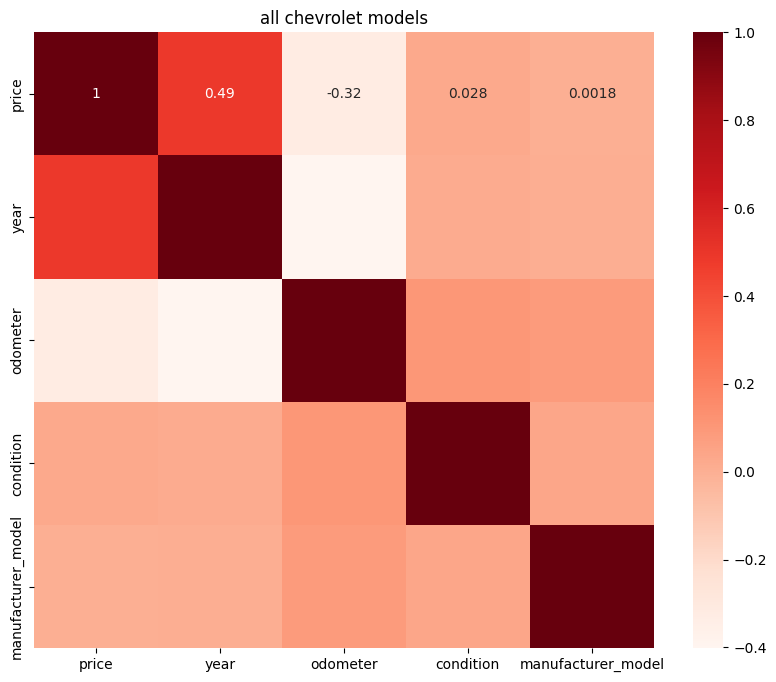

In [1473]:
# Correlation analysis all models of selected manufacturere

correlation_matrix = run_correlation_matrix(cars, 'all chevrolet models')

In [1474]:
best_correlating_model, best_correlations, carmodelnamesuc = search_best_correlating_model(cars)

# Get the actual model name using label_encoder
if best_correlating_model:
    carmodelname = label_encoder.classes_[best_correlating_model].title()
    manufacturer = carmodelname.split('_')[0]
    cmodelname = carmodelname.split('_')[1]
    comboname = manufacturer + " " + cmodelname
    #print(f"The model with the most features strongly correlated with price is '{modelname} encoded:{model_with_most_strong_correlations}' with {max_strong_correlations} strong correlations.")
    print("The best correlation found")
    print("--------------------------")
    print(f'Brand:       {manufacturer}')
    print(f"Model:       {cmodelname}")
    print(f"Encoded:     {best_correlating_model}")
    print(best_correlations)
else:
    print("No model found with a strong correlation with more than one feature.")
    


The best correlation found
--------------------------
Brand:       Chevrolet
Model:       Silverado 1500
Encoded:     744
price        1.000000
year         0.848118
condition    0.317607
odometer    -0.789283
Name: price, dtype: float64


        price    year  odometer  condition
28      22590  2010.0   71229.0     700000
1817    22590  2010.0   71229.0     700000
3010    12882  2010.0  189509.0     800000
3317    14700  2010.0  200392.0    1000000
10016   19999  2010.0   99219.0     800000
...       ...     ...       ...        ...
425020  16995  2011.0  164291.0     700000
425178   9995  2011.0  224964.0    1000000
425466  17998  2011.0  114735.0     800000
426077  20990  2011.0   76508.0     800000
426348  17900  2011.0  124768.0     800000

[3501 rows x 4 columns]


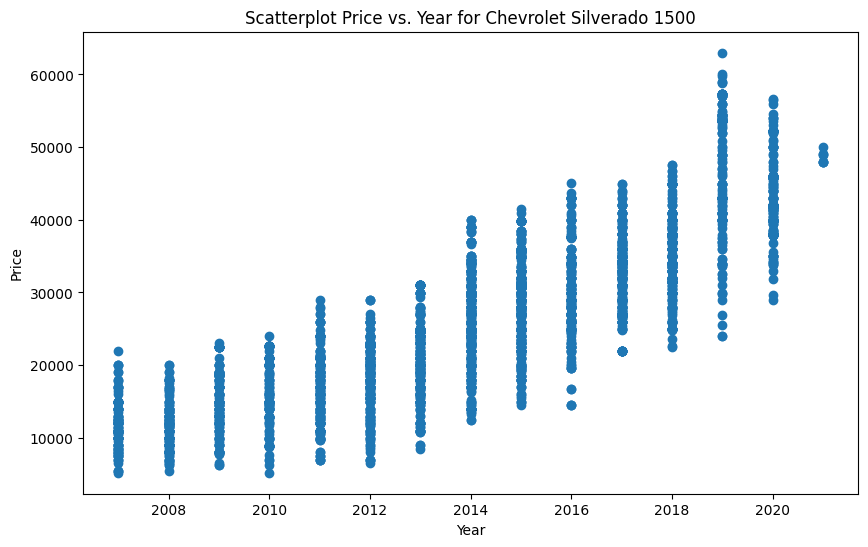

In [1475]:
carmodel_data = get_carmodel_data(carmodelname)
print(carmodel_data)
scatterplot(carmodel_data['year'], carmodel_data['price'], f'Scatterplot Price vs. Year for {comboname}', 'Year', 'Price')


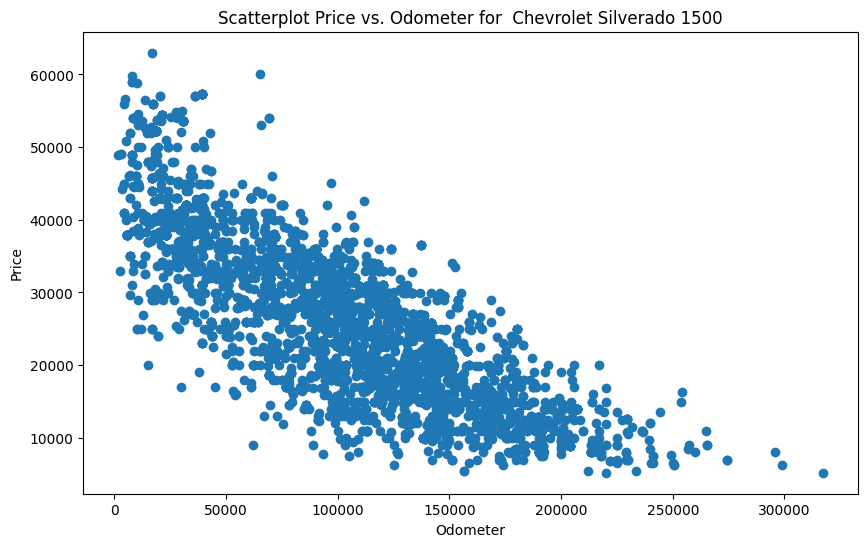

In [1476]:
scatterplot(carmodel_data['odometer'], carmodel_data['price'], f'Scatterplot Price vs. Odometer for  {comboname}', 'Odometer', 'Price')

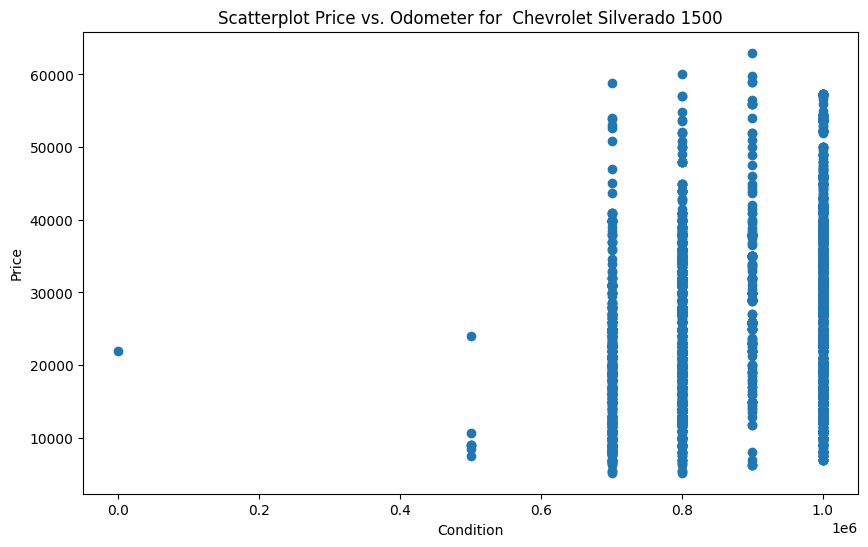

In [1477]:
scatterplot(carmodel_data['condition'], carmodel_data['price'], f'Scatterplot Price vs. Odometer for  {comboname}', 'Condition', 'Price')

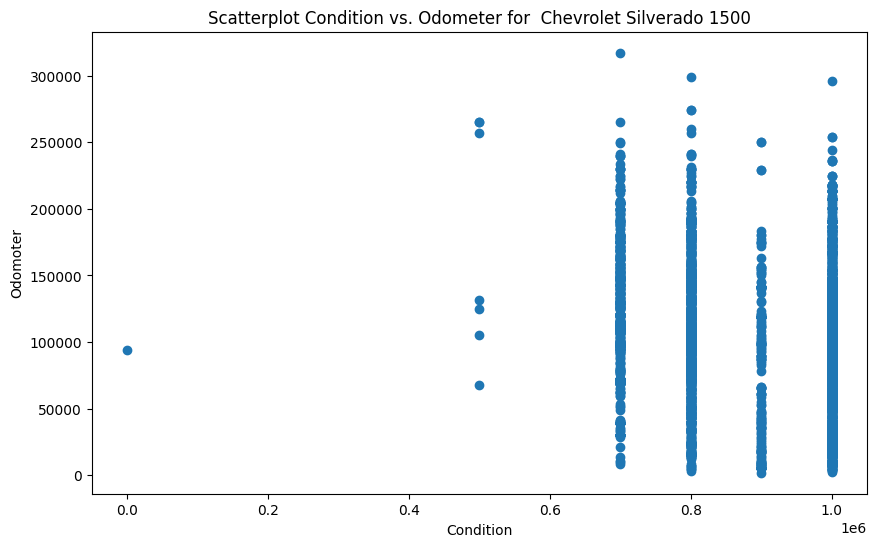

In [1478]:
scatterplot(carmodel_data['condition'], carmodel_data['odometer'], f'Scatterplot Condition vs. Odometer for  {comboname}', 'Condition', 'Odomoter')

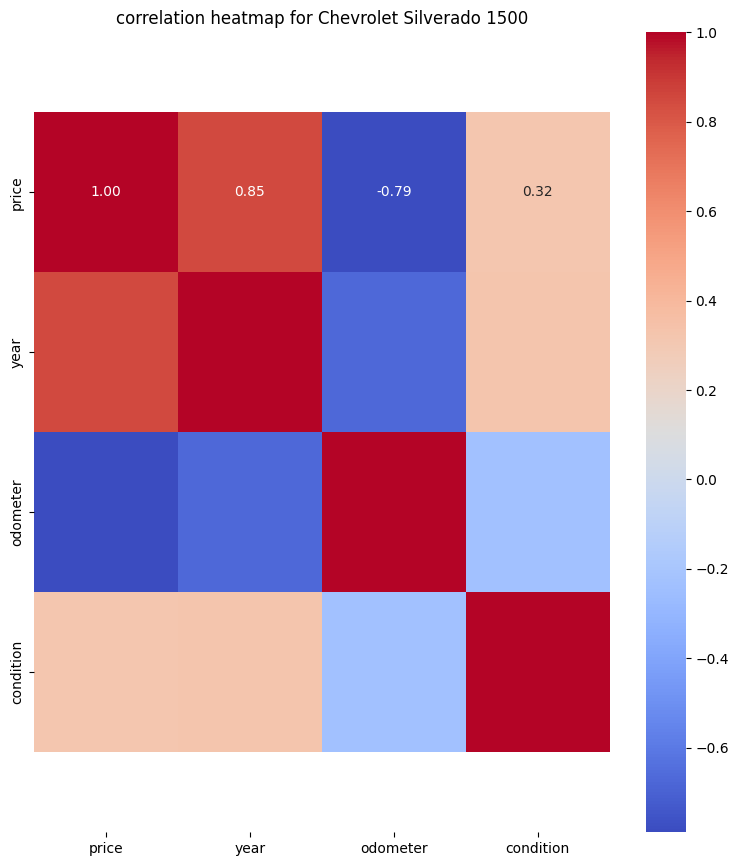

In [1479]:
# build heatmap for 

carmodel_correlation_matrix = carmodel_data.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Draw the heatmap
sns.heatmap(carmodel_correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)

# Adjust layout to make room for the colorbar
plt.subplots_adjust(left=0.2, right=0.8, top=0.9, bottom=0.1)

# Fix for matplotlib bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values

# Show the plot
plt.title(f'correlation heatmap for {comboname}')
plt.show()

### Modeling

In this section we will have the following approach

1) Initialize several modeling instances including LinearRegression, RandomForestRegressor, GradientBoostingRegressor, Ridge and Lasso
2) Setup X, y, X_train, X_test, y_train, y_test for model testing using ['year', 'condition', 'odometer'] features
3) Fit all the models
4) Run predictions using X_test
5) Calculate MSE and R2 for each model and see which one works the best
6) Validate Ridge and Lasso aplha value and iterate
7) Plot Comparison of Regression Model Predictions for each prediction model
8) Plot Comparison of Regression Model Predictions for Random Foreest Regression Model Predictions which seems to be working the best

In [1480]:
# Initialize all prediction models
linear_model = LinearRegression()
random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)
gb_model = GradientBoostingRegressor(random_state=42)
ridge_model = Ridge(alpha=1.0)
lasso_model = Lasso(alpha=0.001)

In [1481]:
# create training and test data for specific model (carmodel_data)

X = carmodel_data[['year', 'condition', 'odometer']] 
y = carmodel_data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [1482]:
# initialize prediction models

linear_model.fit(X_train, y_train)
random_forest_model.fit(X_train, y_train)
gb_model.fit(X_train, y_train)
ridge_model.fit(X_train, y_train)
lasso_model.fit(X_train, y_train)

Lasso(alpha=0.001)

In [1483]:
# Make predictions on the test set suing all prediction models

y_pred_linear = linear_model.predict(X_test)
y_pred_rf = random_forest_model.predict(X_test)
y_pred_gb = gb_model.predict(X_test)
y_pred_ridge = ridge_model.predict(X_test)
y_pred_lasso = lasso_model.predict(X_test)

In [1484]:
# calculate and print mse and rse for each prediction model

from sklearn.metrics import mean_squared_error, r2_score

# Evaluate the model
mse = mean_squared_error(y_test, y_pred_linear)
r2 = r2_score(y_test, y_pred_linear)

print(f"Mean Squared Error Linear: {mse}")
print(f"R^2 Score Linear: {r2}")

mseridge = mean_squared_error(y_test, y_pred_ridge)
r2ridge = r2_score(y_test, y_pred_ridge)

print(f"Mean Squared Error Ridge: {mseridge}")
print(f"R^2 Score Ridge: {r2ridge}")

mselasso = mean_squared_error(y_test, y_pred_lasso)
r2lasso = r2_score(y_test, y_pred_lasso)

print(f"Mean Squared Error Lasso: {mselasso}")
print(f"R^2 Score Lasso: {r2lasso}")

mserf = mean_squared_error(y_test, y_pred_rf)
r2rf = r2_score(y_test, y_pred_rf)

print(f"Mean Squared Error Random Forest: {mserf}")
print(f"R^2 Score Random Forest: {r2rf}")

msegb = mean_squared_error(y_test, y_pred_gb)
r2gb = r2_score(y_test, y_pred_gb)

print(f"Mean Squared Error Gradient Boosting: {msegb}")
print(f"R^2 Score Gradient Boosting: {r2gb}")


Mean Squared Error Linear: 24303473.101552382
R^2 Score Linear: 0.8061823095944434
Mean Squared Error Ridge: 24303446.008851625
R^2 Score Ridge: 0.8061825256559365
Mean Squared Error Lasso: 24303473.05861214
R^2 Score Lasso: 0.8061823099368874
Mean Squared Error Random Forest: 14389334.538277978
R^2 Score Random Forest: 0.8852465417173728
Mean Squared Error Gradient Boosting: 18961781.52669878
R^2 Score Gradient Boosting: 0.8487817487598199


In [1485]:
# calculate optimal aplha for Ridge

# Define a range of alpha values
alpha_values = [0.01, 0.1, 1, 10, 100]

# RidgeCV automatically performs Leave-One-Out Cross-Validation if the dataset is small, or K-Fold CV otherwise
ridge_cv = RidgeCV(alphas=alpha_values, store_cv_values=True)

# Fit model
ridge_cv.fit(X_train, y_train)

# Optimal alpha value
print("Optimal Ridge alpha value:", ridge_cv.alpha_)

Optimal Ridge alpha value: 10.0


In [1486]:
# calculate optimal aplha for Lasso

# Define a range of alpha values
alpha_values = [0.001, 0.01, 0.1, 1, 10]

# LassoCV for automatic alpha selection via cross-validation
lasso_cv = LassoCV(alphas=alpha_values, max_iter=10000, cv=5)

# Fit model
lasso_cv.fit(X_train, y_train)

# Optimal alpha value
print("Optimal Lass oalpha value:", lasso_cv.alpha_)

Optimal Lass oalpha value: 10.0


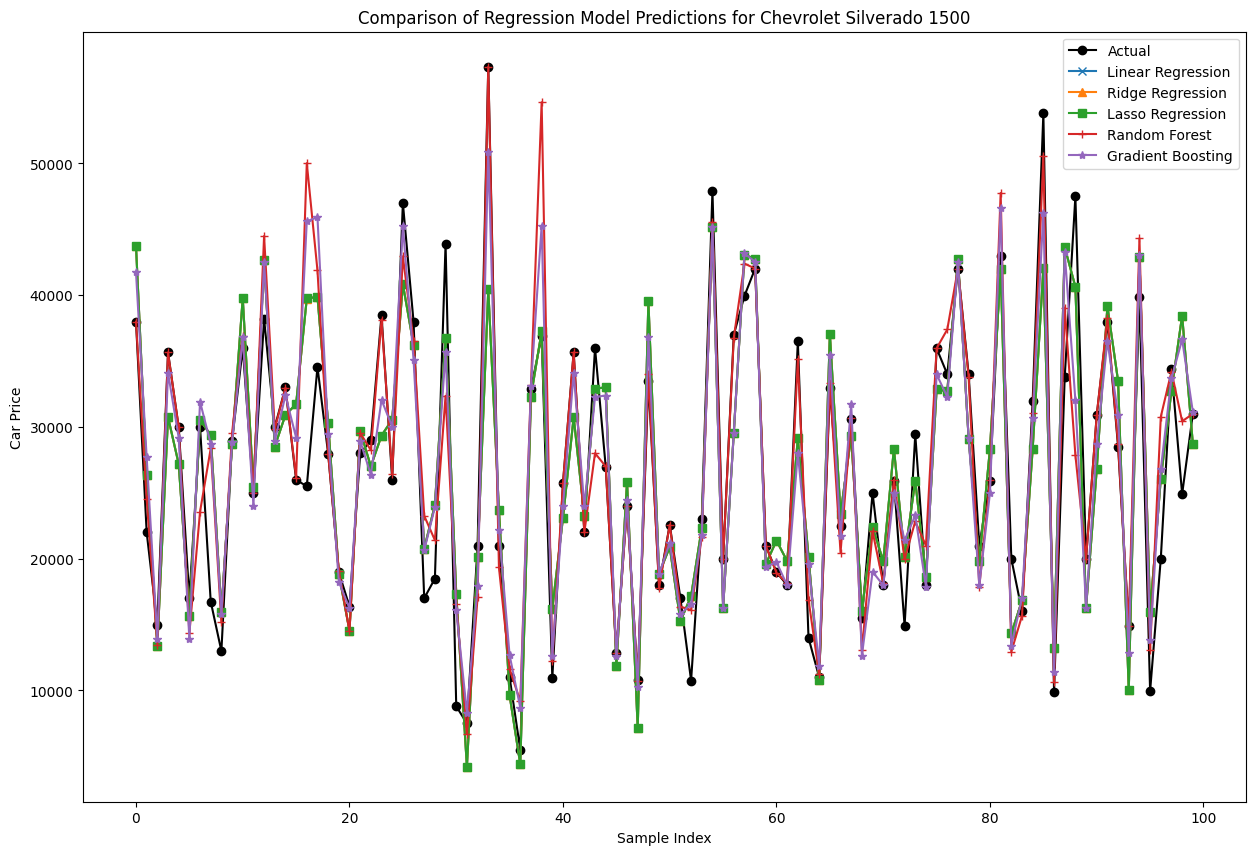

In [1487]:
# print all prediction model restuls in a chart

model_comparision_chart(y_test, y_pred_linear, y_pred_ridge, y_pred_lasso, y_pred_rf, y_pred_gb, comboname)


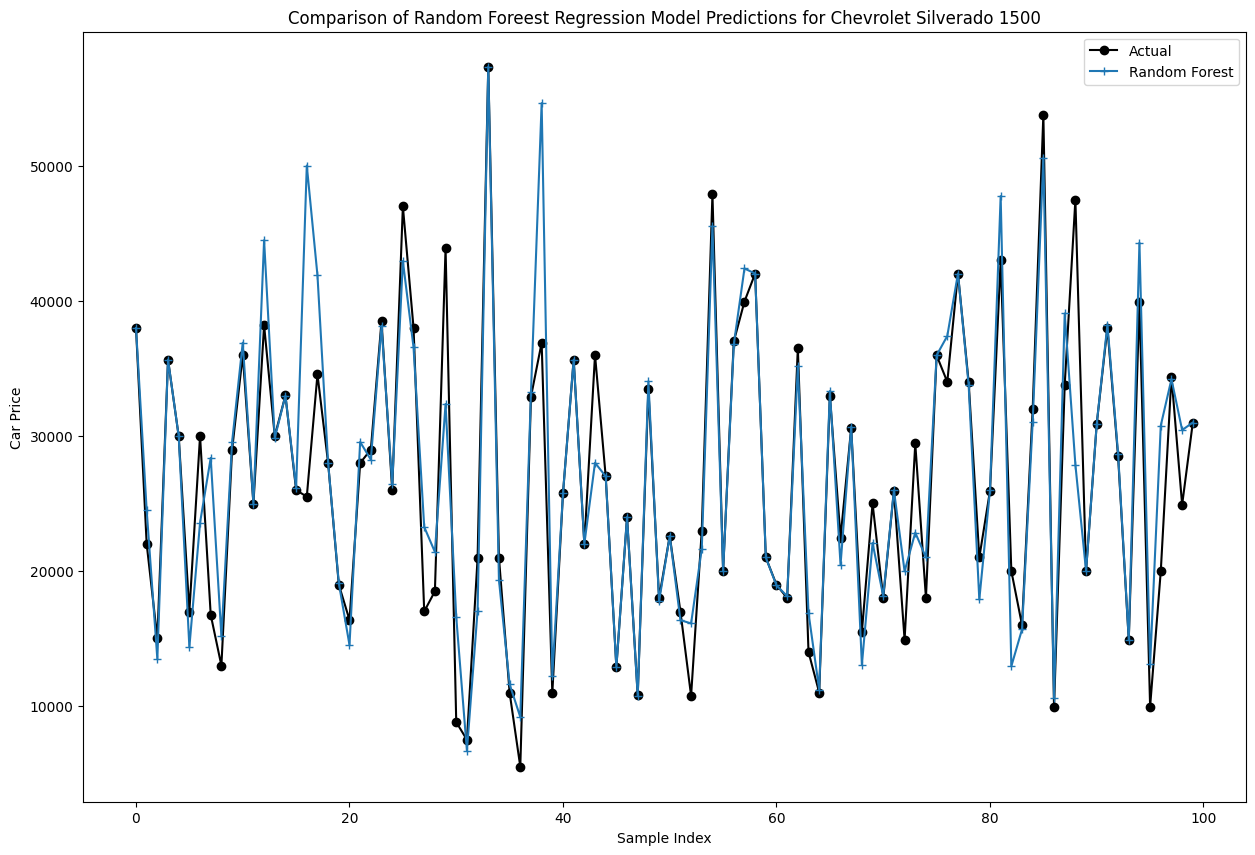

In [1488]:
# print all prediction model restuls in a chart

signle_model_chart(y_test, y_pred_rf, 'Random Foreest Regression', comboname)

### Evaluation

1) Will make test set evaluation using just basic fetuares and try predictions for car prices
2) The will make test set evaluation using just fetuare engineering and try predictions for car prices. Features here are ['year', 'odometer', 'condition', 'year_sqrt', 'odometer_sqrt', 'year_odometer_interaction']
3) the conclusion is that fetuare engineering work better

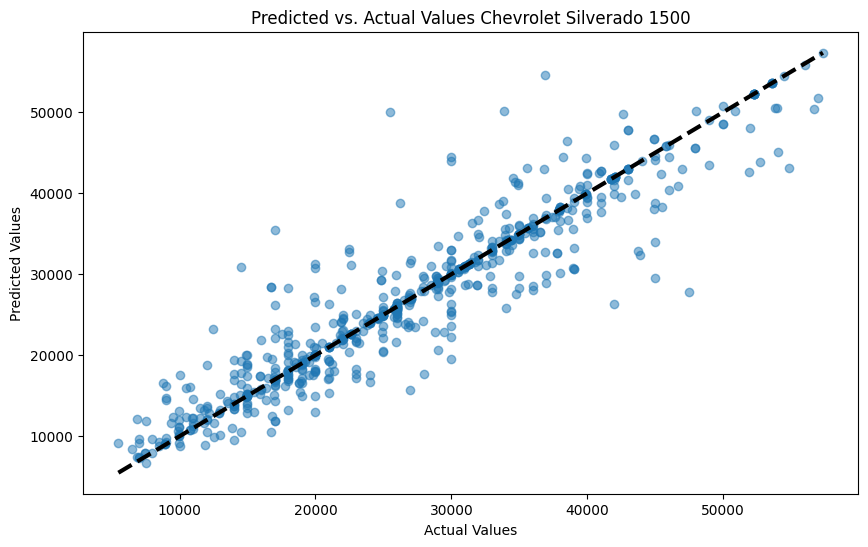

In [1489]:
# run and plot test set evalution using RandomForestRegressor for a specific car model
test_set_evaluation('Chevrolet', 'Silverado 1500')

In [1490]:
car_details = {
    'manufacturer': 'Chevrolet',
    'carmodel': 'Silverado 1500',
    'year': 2020,
    'condition': 'good',
    'odometer': 20000
}



In [1491]:

pred_price = predict_price(linear_model, **car_details)
printcar(car_details)
print(f"linear model predicted price: ${pred_price}")
print("\n")

manufacturer: Chevrolet
carmodel: Silverado 1500
year: 2020
condition: good
odometer: 20000
linear model predicted price: $42665.822794196196




In [1492]:
pred_price = predict_price(random_forest_model, **car_details)
printcar(car_details)
print(f"random_forest model predicted price: ${pred_price}")
print("\n")

manufacturer: Chevrolet
carmodel: Silverado 1500
year: 2020
condition: good
odometer: 20000
random_forest model predicted price: $41026.55




In [1493]:
pred_price = predict_price(gb_model, **car_details)
printcar(car_details)
print(f"gb_model predicted price: ${pred_price}")
print("\n")

manufacturer: Chevrolet
carmodel: Silverado 1500
year: 2020
condition: good
odometer: 20000
gb_model predicted price: $45558.966909505376




In [1494]:
pred_price = predict_price(ridge_model, **car_details)
printcar(car_details)
print(f"ridge_model predicted price: ${pred_price}")
print("\n")

manufacturer: Chevrolet
carmodel: Silverado 1500
year: 2020
condition: good
odometer: 20000
ridge_model predicted price: $42665.473210768774




In [1495]:
pred_price = predict_price(lasso_model, **car_details)
printcar(car_details)
print(f"lasso_model predicted price: ${pred_price}")
print("\n")

manufacturer: Chevrolet
carmodel: Silverado 1500
year: 2020
condition: good
odometer: 20000
lasso_model predicted price: $42665.82224132819




Mean Squared Error: 14649798.638367537
R^2 Score: 0.8831693673932761


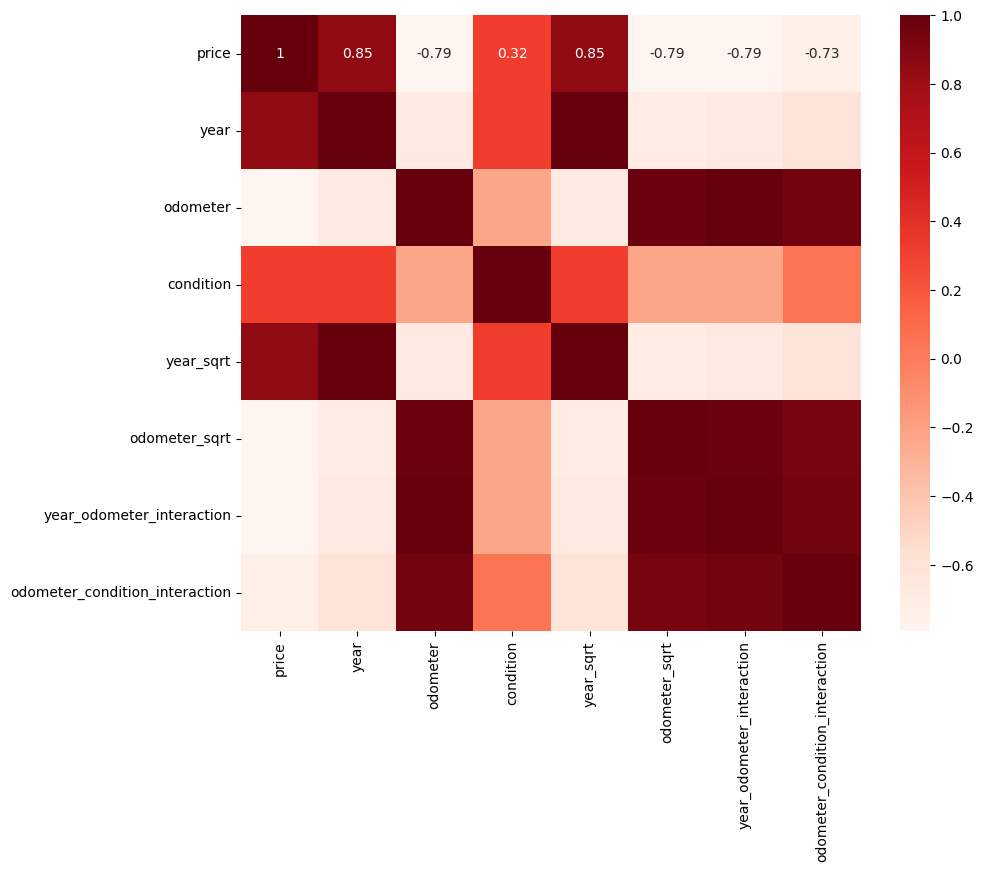

In [1496]:
feature_engineering(**car_details)

year: 0.6377147087707483
odometer: 0.05815826170489271
condition: 0.0034416650980086364
odometer_sqrt: 0.03461631439092266
condition_sqrt: 0.0019968304445071314
year_odometer_interaction: 0.06212899884627214
year_condition_interaction: 0.01660390855414737
odometer_condition_interaction: 0.06083778664572805
odometer_condition_interaction_sqrt: 0.017270399427452263
odometer_log: 0.07512919501137152
odometer_inverse: 0.028996070581147206
condition_cube: 0.003105860524802158


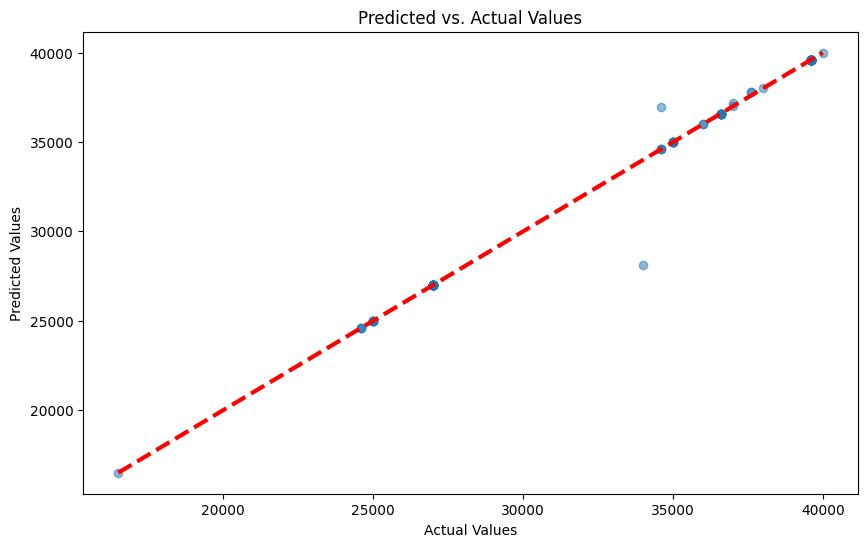

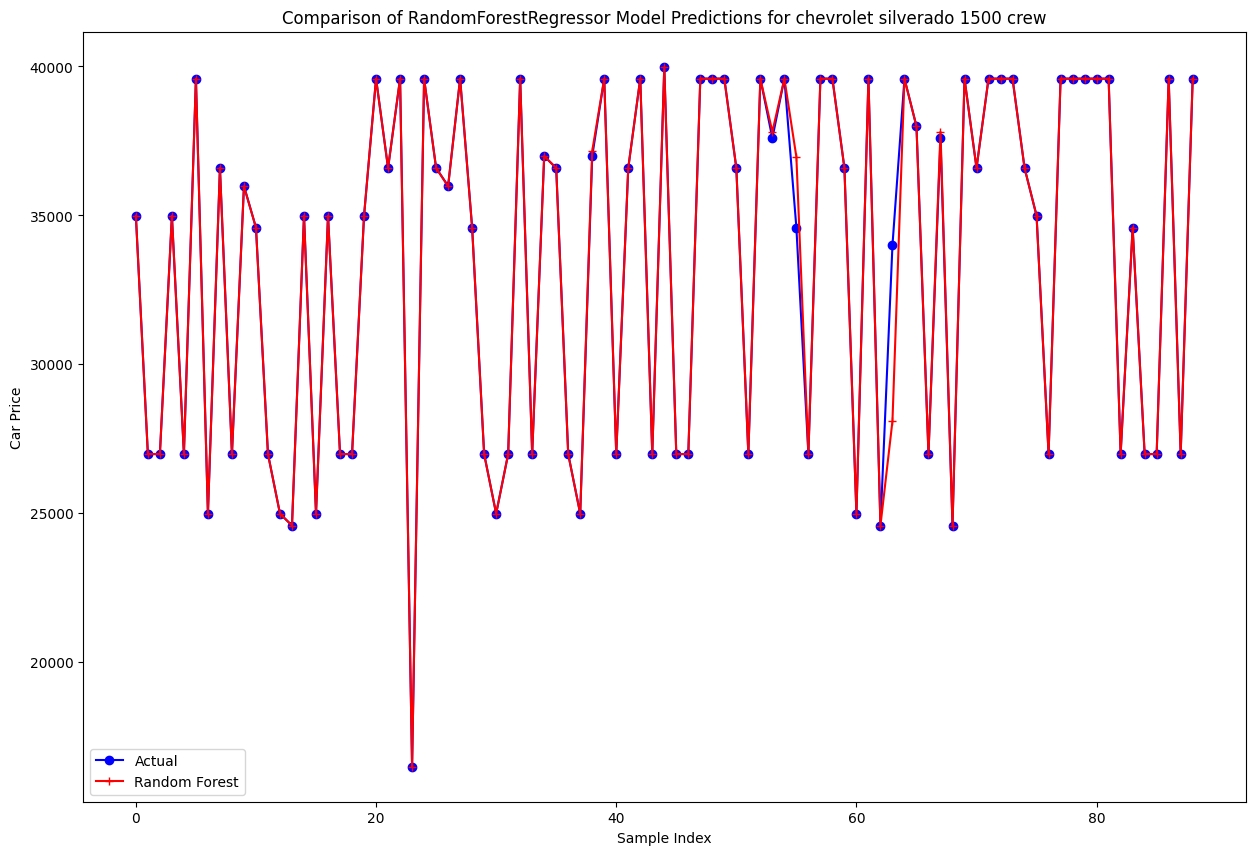

In [1497]:
test_set_evaluation_feat('chevrolet', 'silverado 1500 crew')

In [1498]:
car_details2a = {
    'manufacturer': 'Chevrolet',
    'carmodel': 'Silverado 1500',
    'year': 2020,
    'condition': 'excellent',
    'odometer': 20000
}

pred_price = predict_price_feat(random_forest_model, **car_details2a)
printcar(car_details2a)
print(f"random_forest model predicted price: ${pred_price}")
print("\n")

condition_encoded 800000
manufacturer: Chevrolet
carmodel: Silverado 1500
year: 2020
condition: excellent
odometer: 20000
random_forest model predicted price: $43430.68




In [1499]:
car_details2b = {
    'manufacturer': 'Chevrolet',
    'carmodel': 'Silverado 1500',
    'year': 2020,
    'condition': 'excellent',
    'odometer': 100000
}

pred_price = predict_price_feat(random_forest_model, **car_details2b)
printcar(car_details2b)
print(f"random_forest model predicted price: ${pred_price}")
print("\n")

condition_encoded 800000
manufacturer: Chevrolet
carmodel: Silverado 1500
year: 2020
condition: excellent
odometer: 100000
random_forest model predicted price: $41448.22




In [1500]:
car_details2c = {
    'manufacturer': 'Chevrolet',
    'carmodel': 'Silverado 1500',
    'year': 2020,
    'condition': 'salvage',
    'odometer': 100000
}

pred_price = predict_price_feat(random_forest_model, **car_details2c)
printcar(car_details2c)
print(f"random_forest model predicted price: ${pred_price}")
print("\n")



condition_encoded 1
manufacturer: Chevrolet
carmodel: Silverado 1500
year: 2020
condition: salvage
odometer: 100000
random_forest model predicted price: $42279.795999999995




In [1501]:

car_details3 = {
    'manufacturer': 'Chevrolet',
    'carmodel': 'Silverado 1500',
    'year': 2018,
    'condition': 'salvage',
    'odometer': 20000
}

pred_price = predict_price_feat(random_forest_model, **car_details3)
printcar(car_details3)
print(f"random_forest model predicted price: ${pred_price}")
print("\n")

car_details4 = {
    'manufacturer': 'Chevrolet',
    'carmodel': 'Silverado 1500',
    'year': 2010,
    'condition': 'good',
    'odometer': 20000
}

pred_price = predict_price_feat(random_forest_model, **car_details4)
printcar(car_details4)
print(f"random_forest model predicted price: ${pred_price}")
print("\n")

car_details5 = {
    'manufacturer': 'Chevrolet',
    'carmodel': 'Silverado 1500',
    'year': 2010,
    'condition': 'good',
    'odometer': 200000
}

pred_price = predict_price_feat(random_forest_model, **car_details5)
printcar(car_details5)
print(f"random_forest model predicted price: ${pred_price}")
print("\n")

car_details6 = {
    'manufacturer': 'Chevrolet',
    'carmodel': 'Silverado 1500',
    'year': 2010,
    'condition': 'good',
    'odometer': 300000
}

pred_price = predict_price_feat(random_forest_model, **car_details6)
printcar(car_details6)
print(f"random_forest model predicted price: ${pred_price}")
print("\n")


car_details7 = {
    'manufacturer': 'Chevrolet',
    'carmodel': 'Silverado 1500',
    'year': 2020,
    'condition': 'good',
    'odometer': 500
}

pred_price = predict_price_feat(random_forest_model, **car_details7)
printcar(car_details7)
print(f"random_forest model predicted price: ${pred_price}")
print("\n")


condition_encoded 1
manufacturer: Chevrolet
carmodel: Silverado 1500
year: 2018
condition: salvage
odometer: 20000
random_forest model predicted price: $31538.5396284685


condition_encoded 700000
manufacturer: Chevrolet
carmodel: Silverado 1500
year: 2010
condition: good
odometer: 20000
random_forest model predicted price: $28071.42


condition_encoded 700000
manufacturer: Chevrolet
carmodel: Silverado 1500
year: 2010
condition: good
odometer: 200000
random_forest model predicted price: $9679.25


condition_encoded 700000
manufacturer: Chevrolet
carmodel: Silverado 1500
year: 2010
condition: good
odometer: 300000
random_forest model predicted price: $7491.55


condition_encoded 700000
manufacturer: Chevrolet
carmodel: Silverado 1500
year: 2020
condition: good
odometer: 500
random_forest model predicted price: $42059.93




In [1505]:
car_details8 = {
    'manufacturer': 'mercedes-benz',
    'carmodel': 'm-class',
    'year': 2014,
    'condition': 'good',
    'odometer': 50000
}

pred_price = predict_price_feat(random_forest_model, **car_details8)
printcar(car_details8)
print(f"random_forest model predicted price: ${pred_price}")
print("\n")

#reference column from the dataset
#7315746793,birmingham,24997,2014,mercedes-benz,m-class,,8 cylinders,gas,82553,clean,automatic,4JGDA7DBXEA336979,,,SUV,blue,al

condition_encoded 700000
manufacturer: mercedes-benz
carmodel: m-class
year: 2014
condition: good
odometer: 50000
random_forest model predicted price: $23023.6025




### Deployment

Looks like in my feature engineered model year seems to work and odometer have some impact but I shall continue working on feature engineering and precition model test to find better way to predict
using also condition, now it has very little effect if any, despite of the fact that I did convert condition labels to numbers from high (new) to low (salvage)
also my ulity functions have some overhead to copy the original data multiple times and I can likely optimze that to make this process much faster.
predictions you can see from adove.

My customer was asking how much she would get from 2014 Mercedes-Benz, mileage: 50000 and condition: good
My model says: $23023